# Реалистичная генерация данных для обратной задачи ЭЭГ


Этот ноутбук демонстрирует создание реалистичных EEG данных с:

- Датчиками на сферической поверхности (имитация EEG шапочки)

- Множественными источниками сигнала с временными пиками

- Пространственно-временной корреляцией сигналов

- Интеграцией с решателем обратной задачи

In [1]:
# Импорт необходимых библиотек

import sys
sys.path.append('../src')
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Импорт наших модулей
from inverse_npde.eeg_data_generator import (
    EEGDataGenerator, 
    create_eeg_experiment

)
from inverse_npde.julia_interface import EEGInverseSolver

print("✓ Все модули успешно загружены")

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
✓ Все модули успешно загружены


🧠 Создание реалистичного EEG эксперимента...
🧠 Создание EEG эксперимента для головы adult...
📊 Параметры сигнала: 50 Гц × 1 сек
📊 Параметры сигнала: 50 Гц × 1 сек = 50 отсчетов
Добавлен источник в позиции [-3.0, 2.0, 1.0]
Добавлен источник в позиции [3.0, -1.0, 2.0]
Сгенерировано 800 измеренных точек для головы adult
Визуализация датчиков сохранена: figures/eeg_sensors_adult.png


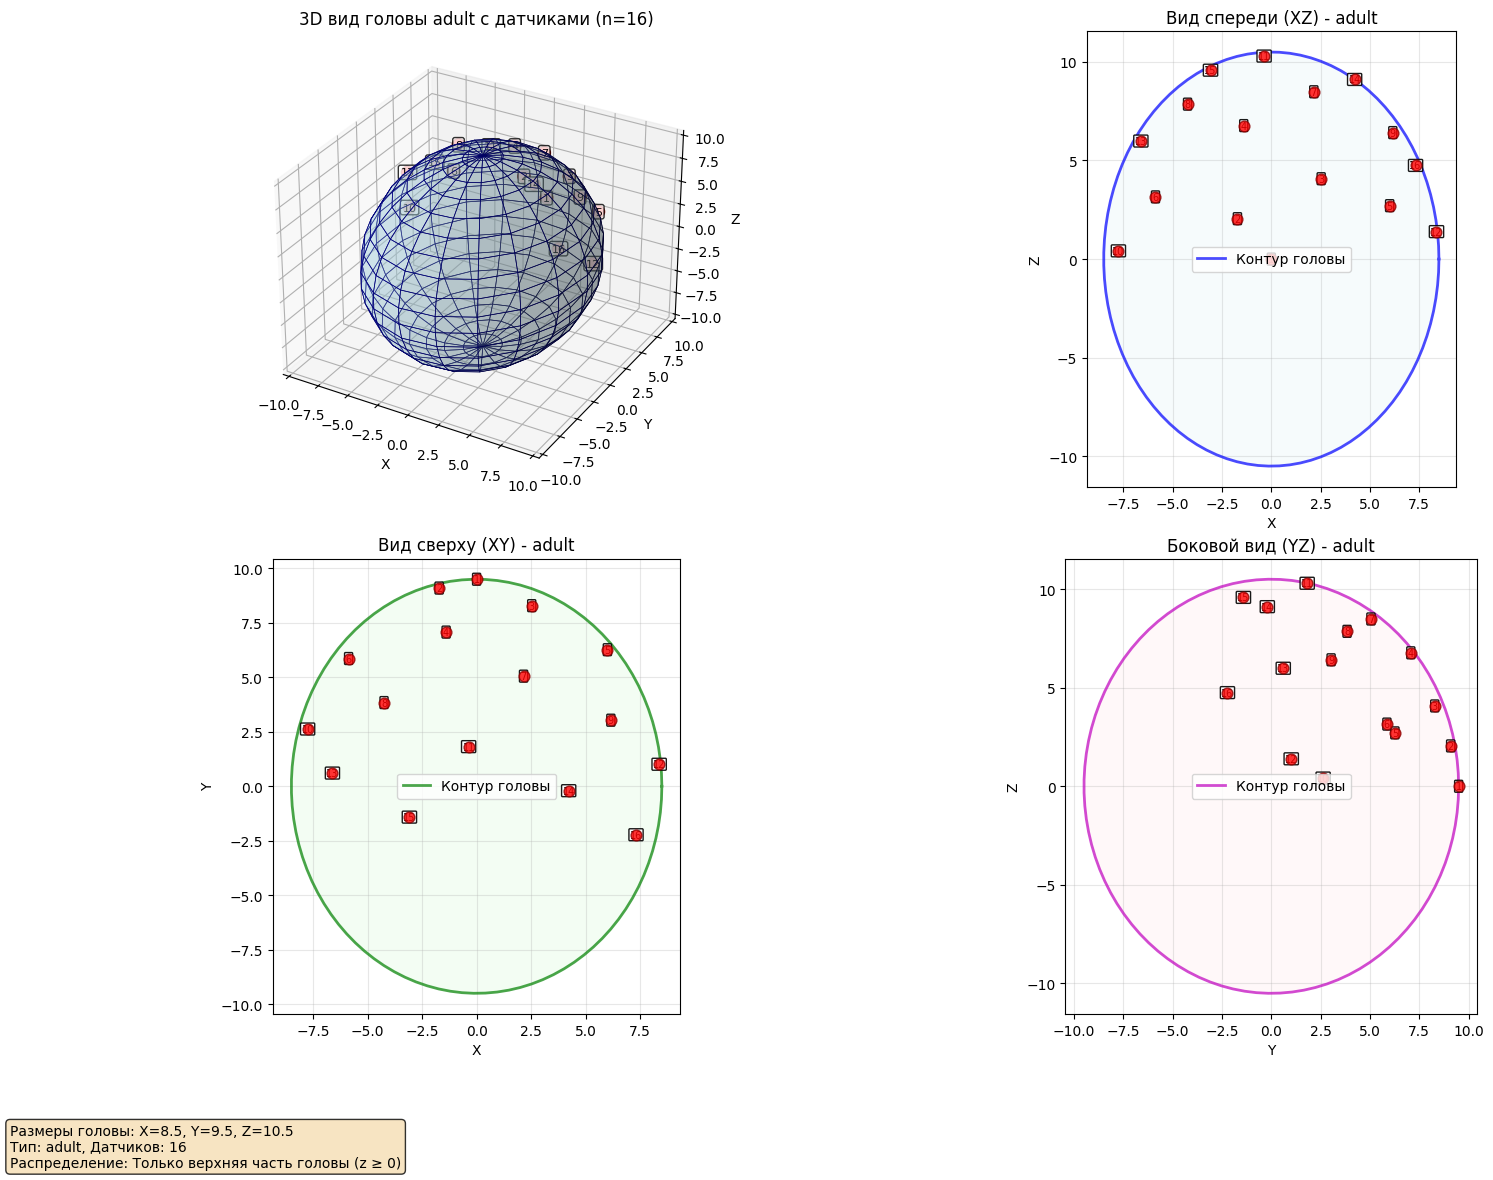

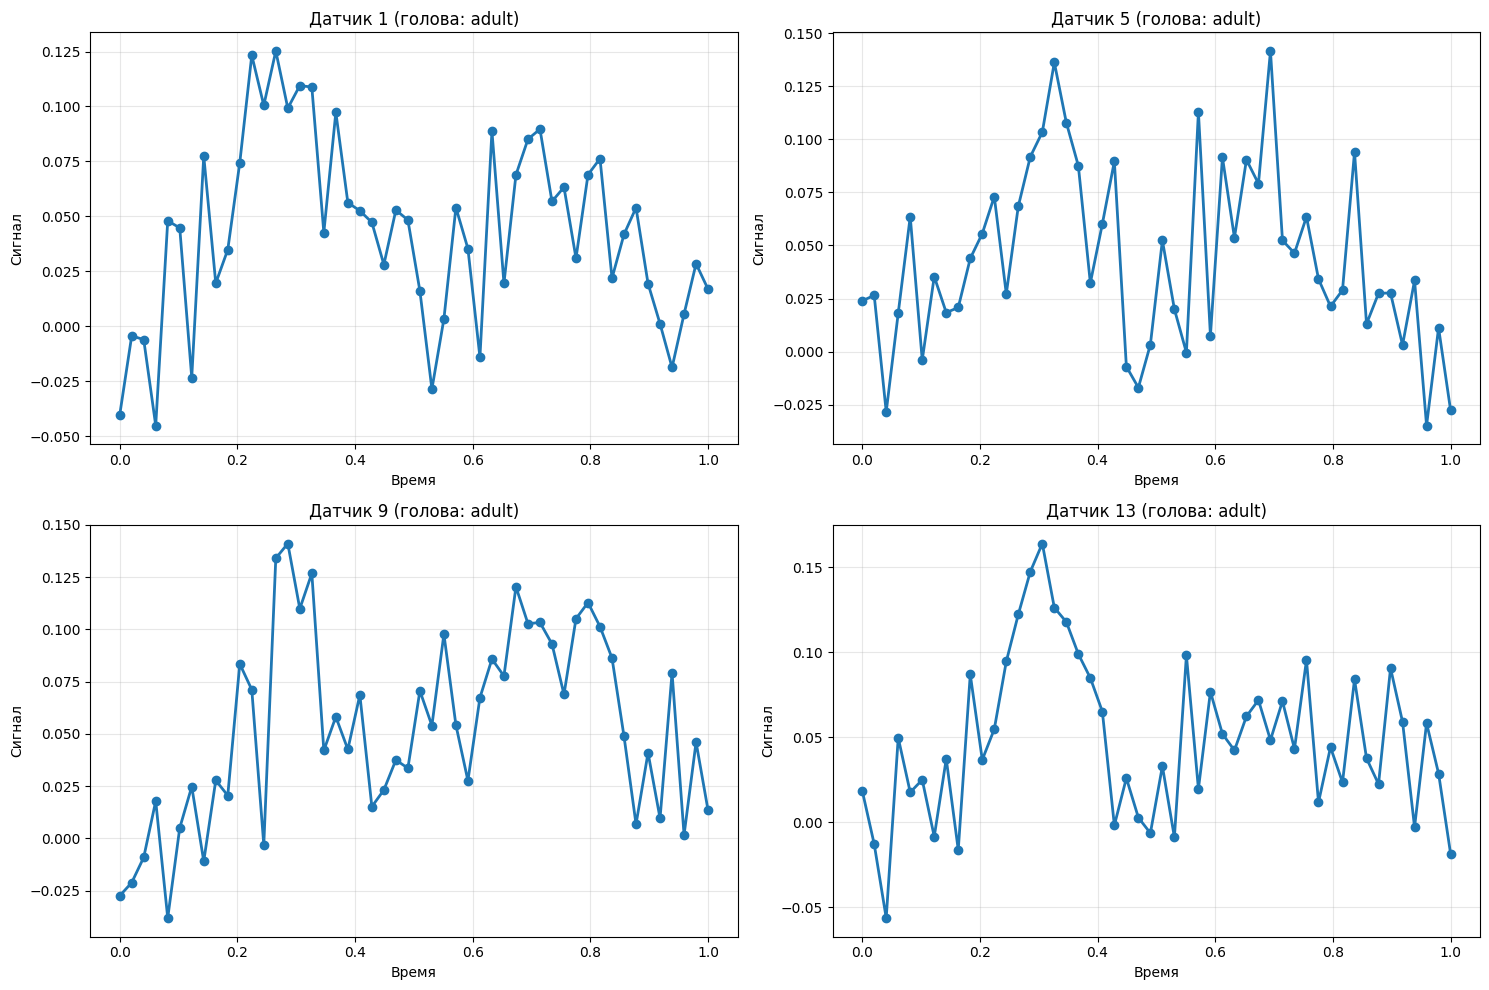

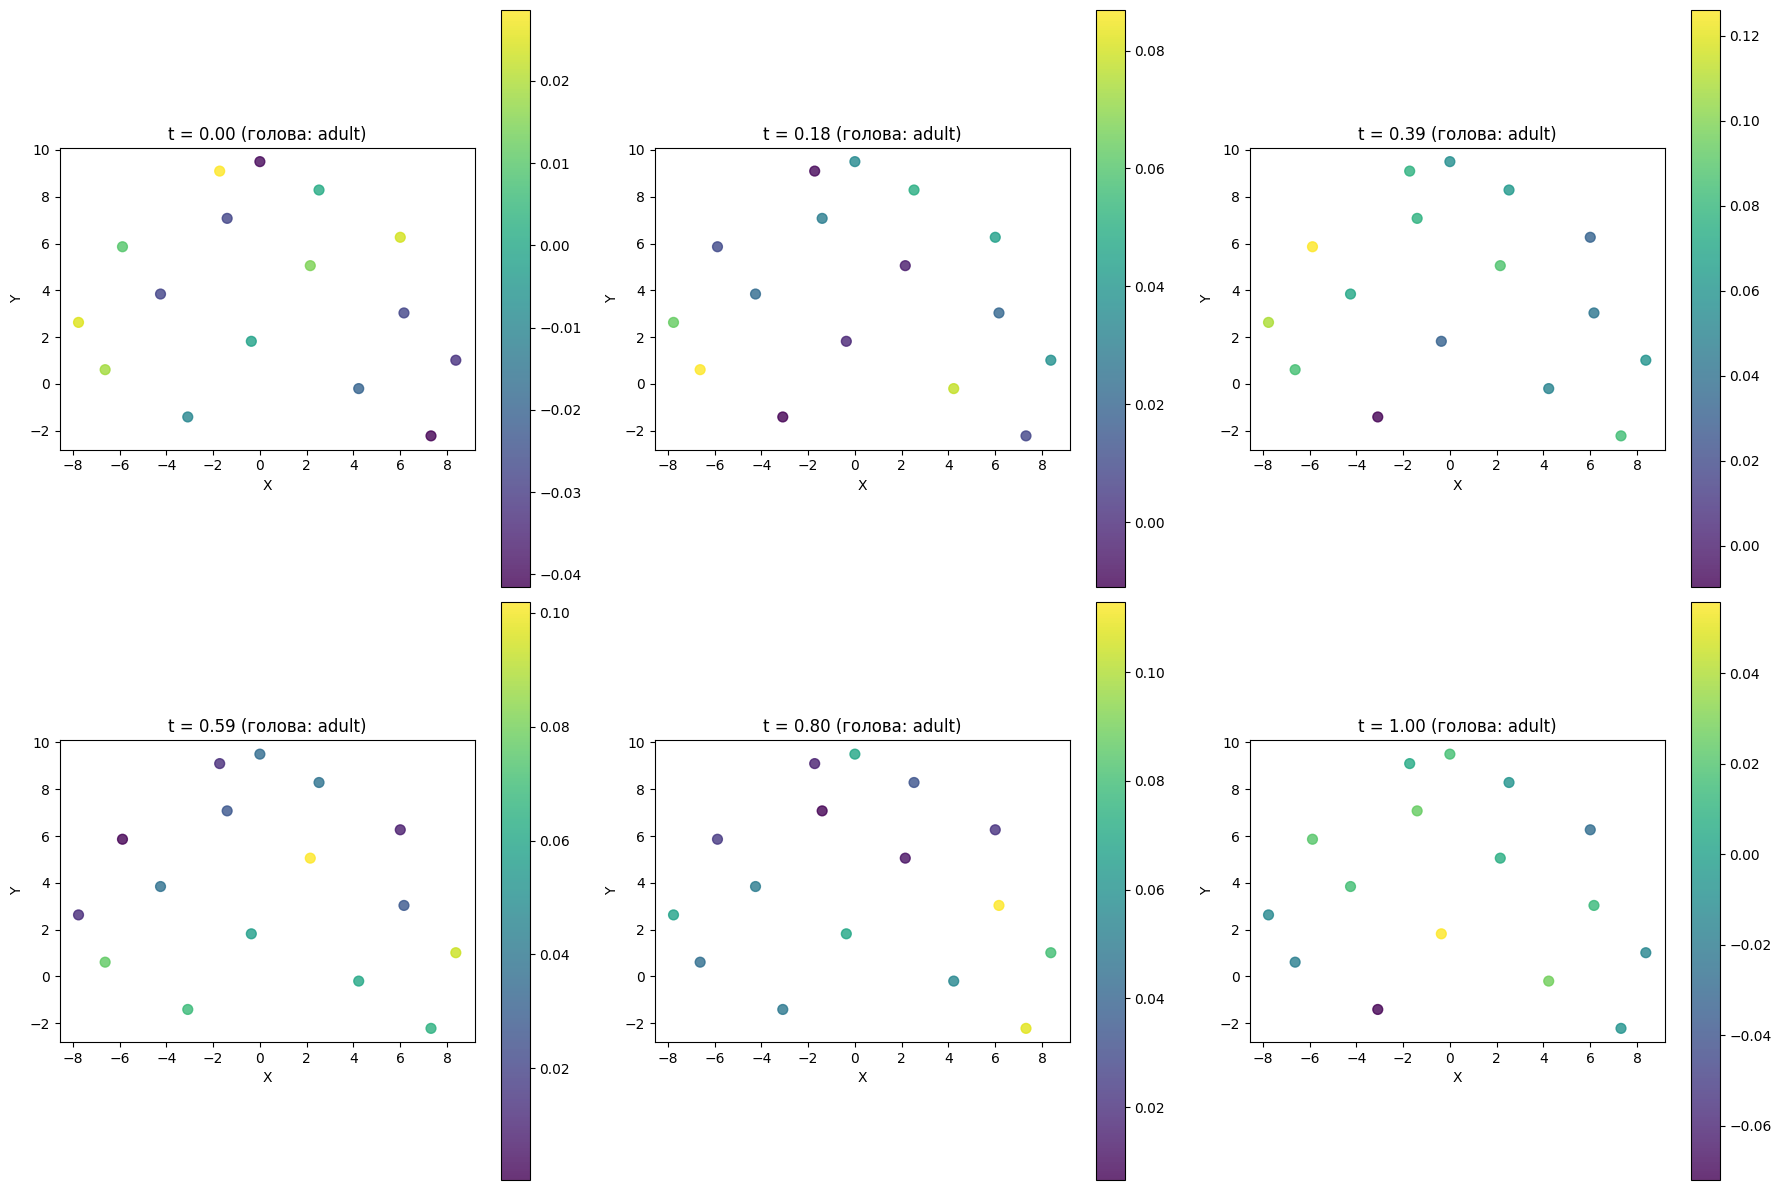

Визуализация сохранена в figures
✅ EEG эксперимент для головы adult создан!
📊 Сгенерировано 800 измеренных точек
📍 Количество датчиков: 16
⏰ Временных точек: 50
⚡ Источников сигнала: 2


In [2]:
## Шаг 1: Создание реалистичного EEG эксперимента
# Создаем EEG эксперимент с реалистичными параметрами
n_sensors = 16
print("🧠 Создание реалистичного EEG эксперимента...")

# Генерируем данные
measured_points, generator = create_eeg_experiment(
    num_sensors=n_sensors,        # 32 датчика (для быстрого теста)
    sampling_rate = 50,
    duration = 1,
    noise_level=0.03,      # Уровень шума 1%
    save_visualization=True

)

print(f"📊 Сгенерировано {len(measured_points)} измеренных точек")
print(f"📍 Количество датчиков: {generator.num_sensors}")
print(f"⏰ Временных точек: {generator.num_time_points}")
print(f"⚡ Источников сигнала: {len(generator.sources)}")

In [3]:
## Шаг 2: Анализ сгенерированных данных
# Показываем структуру данных

print("🔍 Анализ структуры данных:")
print("\nПервая измеренная точка:")
print(f"  Координаты: x={measured_points[0][0]:.2f}, y={measured_points[0][1]:.2f}, z={measured_points[0][2]:.2f}")
print(f"  Время: t={measured_points[0][3]:.2f}")
print(f"  Сигнал: φ={measured_points[0][4]:.4f}")
print("\nДиапазоны данных:")

coords = np.array(measured_points)[:, :3]
times = np.array(measured_points)[:, 3]
signals = np.array(measured_points)[:, 4]

print(f"  Координаты X: [{coords[:, 0].min():.2f}, {coords[:, 0].max():.2f}]")
print(f"  Координаты Y: [{coords[:, 1].min():.2f}, {coords[:, 1].max():.2f}]")
print(f"  Координаты Z: [{coords[:, 2].min():.2f}, {coords[:, 2].max():.2f}]")
print(f"  Время: [{times.min():.2f}, {times.max():.2f}]")
print(f"  Сигнал: [{signals.min():.4f}, {signals.max():.4f}]")

measured_points

🔍 Анализ структуры данных:

Первая измеренная точка:
  Координаты: x=0.00, y=9.50, z=0.00
  Время: t=0.00
  Сигнал: φ=-0.0404

Диапазоны данных:
  Координаты X: [-7.75, 8.38]
  Координаты Y: [-2.22, 9.50]
  Координаты Z: [0.00, 10.29]
  Время: [0.00, 1.00]
  Сигнал: [-0.0720, 0.2187]


[[0.0, 9.5, 0.0, 0.0, -0.04040112725376501],
 [-1.7184558864720527,
  9.095744680851064,
  2.0470076510144857,
  0.0,
  0.028617365575988034],
 [2.5284535152843577,
  8.287234042553191,
  4.07390101595024,
  0.0,
  0.0011696739988120647],
 [-1.399117253392673,
  7.074468085106384,
  6.767651723188474,
  0.0,
  -0.027564950021822264],
 [6.001261196524371,
  6.26595744680851,
  2.7073335434742183,
  0.0,
  0.023941499810631175],
 [-5.8738395536734584,
  5.861702127659575,
  3.152776915776664,
  0.0,
  0.009666523872163869],
 [2.1541798507545855,
  5.053191489361702,
  8.483833006608165,
  0.0,
  0.014594716403271165],
 [-4.247772484067741,
  3.840425531914894,
  7.8564956174635245,
  0.0,
  -0.027772568075666502],
 [6.159621468813349,
  3.0319148936170213,
  6.41282619963503,
  0.0,
  -0.027506461076377282],
 [-7.753338307742422,
  2.6276595744680846,
  0.41691160994437715,
  0.0,
  0.02485564086523498],
 [-0.3660935203223963,
  1.8191489361702133,
  10.294693992145207,
  0.0,
  -0.00139

In [4]:
## Шаг 3: Настройка решателя обратной задачи
# Создаем решатель с оптимизированными параметрами для EEG

print("⚙️ Настройка решателя обратной задачи...")

solver = EEGInverseSolver(
    constants={
        'c': 2.99792458e10,  # Скорость света
        'epsilon': 1.0,      # Диэлектрическая проницаемость
        'mu': 1.0,           # Магнитная проницаемость
    },

    neural_config={
            "input_dim": 4,  # x, y, z, t
            "hidden_layers": [32, 32],  # Скрытые слои
            "output_dim": 8,  # φ, Ax, Ay, Az, ρ, jx, jy, jz
            "activation": "σ",  # sigmoid activation
            "use_gpu": True,  # Использовать GPU если доступен
    },

    optimization_config={
        'optimizer': 'adam',
        'learning_rate': 0.001,
        'max_iterations': 500,  # Увеличиваем для EEG
        'log_frequency': 25,
        'use_tensorboard': False,

    },

    domain={
        'x_range': [-20.0, 20.0],
        'y_range': [-20.0, 20.0],
        'z_range': [-20.0, 20.0],
        't_range': [0.0, 1],  # Соответствует продолжительности 0.5 сек
        'num_points': 100,
    },
    loss_config = {
        "lambda_pde": 1.0,
        "lambda_bc": 1.0,
        "lambda_data": 30.0,
    }
)

print("✓ Решатель настроен для EEG данных")
print(f"Нейронная сеть: {solver.neural_config['hidden_layers']}")
print(f"Активация: {solver.neural_config['activation']}")
print(f"Итераций: {solver.optimization_config['max_iterations']}")

INFO:inverse_npde.julia_interface:Предварительная загрузка критических модулей...


⚙️ Настройка решателя обратной задачи...


Stacktrace:
 [1] pkgerror(msg::String)
   @ Pkg.Types ~/.julia/juliaup/julia-1.11.8+0.x64.linux.gnu/share/julia/stdlib/v1.11/Pkg/src/Types.jl:68
 [2] activate(path::String; shared::Bool, temp::Bool, io::IOContext{IO})
   @ Pkg.API ~/.julia/juliaup/julia-1.11.8+0.x64.linux.gnu/share/julia/stdlib/v1.11/Pkg/src/API.jl:1356
 [3] top-level scope
   @ none:1
 [4] eval
   @ ./boot.jl:430 [inlined]
 [5] eval
   @ ./Base.jl:130 [inlined]
 [6] pyjlmodule_seval(self::Module, expr::Py)
   @ PythonCall.JlWrap ~/.julia/packages/PythonCall/83z4q/src/JlWrap/module.jl:13
 [7] _pyjl_callmethod(f::Any, self_::Ptr{PythonCall.C.PyObject}, args_::Ptr{PythonCall.C.PyObject}, nargs::Int64)
   @ PythonCall.JlWrap ~/.julia/packages/PythonCall/83z4q/src/JlWrap/base.jl:65
 [8] _pyjl_callmethod(o::Ptr{PythonCall.C.PyObject}, args::Ptr{PythonCall.C.PyObject})
   @ PythonCall.JlWrap.Cjl ~/.julia/packages/PythonCall/83z4q/src/JlWrap/C.jl:63
INFO:inverse_npde.julia_interface:Загрузка OpenSSL_jll...
ERROR:inverse_npde.

📦 InverseProblem модуль загружен
🖥️  Доступные устройства: Dict{String, Any}("cuda_device_count" => 1, "cpu" => true, "cuda_device_name" => ["NVIDIA GeForce RTX 3080"], "cuda" => true)


INFO:inverse_npde.julia_interface:Julia модуль InverseNpde загружен через JuliaCall
INFO:inverse_npde.julia_interface:EEGInverseSolver инициализирован с JuliaCall


✓ Решатель настроен для EEG данных
Нейронная сеть: [32, 32]
Активация: σ
Итераций: 500


In [ ]:
## Шаг 4: Запуск обратной задачи
# Запускаем решение обратной задачи с реальными EEG данными



results = solver.solve(measured_points, save_results=False)
if results['solved']:
    print("\nЭксперимент завершен успешно!")
    print(f"Финальная ошибка: {results['metrics']['final_loss']:.6f}")
    print(f"Общий MSE: {results['metrics']['overall_mse']:.6f}")
    print(f"Общий MAE: {results['metrics']['overall_mae']:.6f}")
    print(f"Максимальная ошибка: {results['metrics']['overall_max_error']:.6f}")
    print(f"Средний MSE по времени: {results['metrics']['avg_time_mse']:.6f}")
    print(f"Средний MAE по времени: {results['metrics']['avg_time_mae']:.6f}")

    # Сохраняем результаты для дальнейшего анализа
    results_file = "eeg_inverse_results.json"
    import json
    with open(results_file, 'w') as f:
        # Конвертируем numpy массивы в списки для JSON
        json_results = {
            'metrics': results['metrics'],
            'solved': results['solved'],
            'experiment_config': results['experiment_config'],
            'statistics': results['statistics'],
            'time_steps': results['time_steps'],
            'sensor_data': results['sensor_data'],
            'time_step_metrics': results['time_step_metrics']
        }
        json.dump(json_results, f, indent=2)
    print(f"Результаты сохранены в {results_file}")
else:
    print("Эксперимент завершился неудачно")



INFO:inverse_npde.julia_interface:Запуск решения обратной задачи ЭЭГ...
INFO:inverse_npde.julia_interface:Передано измеренных точек: 800


🚀 Запуск эксперимента обратной задачи ЭЭГ...
✓ Используем предоставленные измеренные точки


┌ Warning: Lux layers are stateless and hence don't participate in device transfers. Apply this function on the parameters and states generated using `LuxCore.setup`.
└ @ LuxCoreMLDataDevicesExt ~/.julia/packages/LuxCore/qsnGJ/ext/LuxCoreMLDataDevicesExt.jl:10
[ Info: Constructing PhysicsInformedNN (GPU-first). Ensure chain and params are on desired device


✓ Настройка создана
✓ Discretization создан
✓ PDE система дискретизирована
🔄 Начинаем оптимизацию...


┌ Warning: Mixed-Precision `matmul_cpu_fallback!` detected and Octavian.jl cannot be used for this set of inputs (C [Matrix{Float64}]: A [Base.ReshapedArray{Float32, 2, SubArray{Float32, 1, Vector{Float32}, Tuple{UnitRange{Int64}}, true}, Tuple{}}] x B [Matrix{Float64}]). Falling back to generic implementation. This may be slow.
└ @ LuxLib.Impl ~/.julia/packages/LuxLib/utJLG/src/impl/matmul.jl:190
0.2%┣                                          ┫ 1/500 [01:53<Inf:Inf, InfGs/it]
0.4%┣┫ 2/500 [01:56<16:04:08, 116s/it, Loss: 56.597, PDE_losses: 52.968, BC_losses: 2.918]
0.6%┣┫ 3/500 [01:58<08:06:57, 59s/it, Loss: 52.800, PDE_losses: 49.379, BC_losses: 2.722]
0.8%┣┫ 4/500 [01:59<05:27:42, 40s/it, Loss: 49.215, PDE_losses: 46.159, BC_losses: 2.537]
1.0%┣┫ 5/500 [02:01<04:09:28, 30s/it, Loss: 45.876, PDE_losses: 43.056, BC_losses: 2.362]
1.2%┣┫ 6/500 [02:02<03:21:11, 24s/it, Loss: 42.652, PDE_losses: 39.953, BC_losses: 2.197]
1.4%┣┫ 7/500 [02:04<02:49:13, 21s/it, Loss: 39.717, PDE_losses: 37.

In [ ]:
results

{'metrics': {'final_loss': 2.12254341688618,
  'overall_mse': 0.002653179271107725,
  'overall_mae': 0.04050012907662698,
  'overall_max_error': 0.22498214687911108,
  'avg_time_mse': 0.002653179271107725,
  'avg_time_mae': 0.04050012907662698,
  'avg_time_max_error': 0.10685821205569619},
 'time_step_metrics': {0.8979591836734693: {'mse': 0.0007819931873788161,
   'num_sensors': 16.0,
   'max_error': 0.05718742610538889,
   'mae': 0.02090849264817896},
  0.12244897959183673: {'mse': 0.003581842010585657,
   'num_sensors': 16.0,
   'max_error': 0.09921909099184664,
   'mae': 0.05398867748414281},
  0.1020408163265306: {'mse': 0.0021481065337935804,
   'num_sensors': 16.0,
   'max_error': 0.08531344745491559,
   'mae': 0.0356431474613827},
  0.5918367346938775: {'mse': 0.0018128605267455774,
   'num_sensors': 16.0,
   'max_error': 0.09785431446521735,
   'mae': 0.03563465972777313},
  0.6938775510204082: {'mse': 0.0029179188586196435,
   'num_sensors': 16.0,
   'max_error': 0.1248405481

📈 Создание графика изменения потенциала на датчике...
Всего датчиков: 800
Временных шагов: 50
Анализируем датчик #400 в позиции (0.0, 9.5, 0.0)


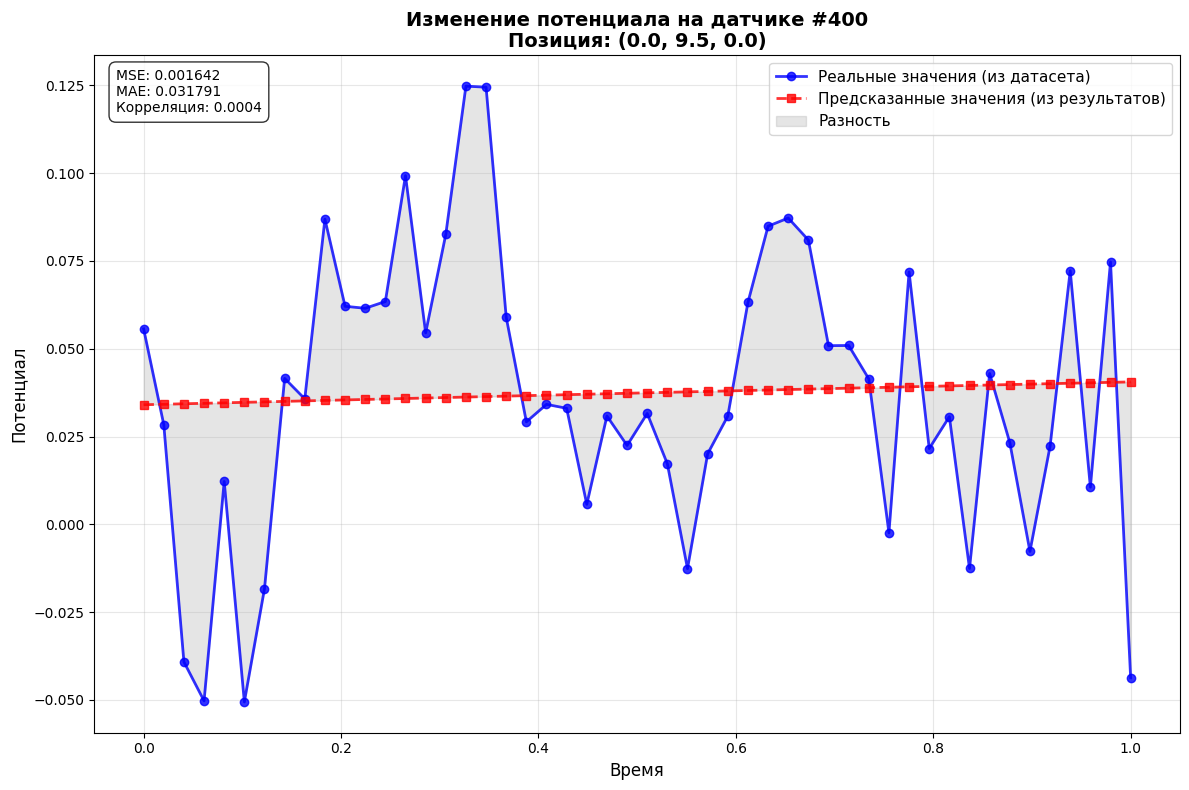

✅ График сохранен в figures/sensor_potential_comparison.png
📊 Статистика для датчика #400:
   MSE: 0.001642
   MAE: 0.031791
   Корреляция: 0.0004


In [ ]:
# Простой график изменения потенциала на датчике со временем
import numpy as np
import matplotlib.pyplot as plt

print("📈 Создание графика изменения потенциала на датчике...")

# Извлекаем данные из результатов
sensor_data = results['sensor_data']
time_steps = results['time_steps']

# Координаты и значения потенциала
x_coords = sensor_data['x_coords']
y_coords = sensor_data['y_coords']
z_coords = sensor_data['z_coords']
t_coords = sensor_data['t_coords']
measured_phi = sensor_data['measured_phi']
predicted_phi = sensor_data['predicted_phi']

print(f"Всего датчиков: {len(x_coords)}")
print(f"Временных шагов: {len(time_steps)}")

# Выбираем центральный датчик (или любой другой по индексу)
sensor_idx = len(x_coords) // 2  # Центральный датчик
print(f"Анализируем датчик #{sensor_idx} в позиции ({x_coords[sensor_idx]:.1f}, {y_coords[sensor_idx]:.1f}, {z_coords[sensor_idx]:.1f})")

# Группируем данные по времени для выбранного датчика
measured_times = []
measured_values = []
predicted_values = []

# Собираем все точки для этого датчика
for i in range(len(x_coords)):
    if (abs(x_coords[i] - x_coords[sensor_idx]) < 0.1 and 
        abs(y_coords[i] - y_coords[sensor_idx]) < 0.1 and 
        abs(z_coords[i] - z_coords[sensor_idx]) < 0.1):
        measured_times.append(t_coords[i])
        measured_values.append(measured_phi[i])
        predicted_values.append(predicted_phi[i])

# Сортируем по времени
sorted_indices = np.argsort(measured_times)
time_sorted = [measured_times[i] for i in sorted_indices]
measured_sorted = [measured_values[i] for i in sorted_indices]
predicted_sorted = [predicted_values[i] for i in sorted_indices]

# Создаем график
plt.figure(figsize=(12, 8))

plt.plot(time_sorted, measured_sorted, 'b-o', linewidth=2, markersize=6, 
         label='Реальные значения (из датасета)', alpha=0.8)

plt.plot(time_sorted, predicted_sorted, 'r--s', linewidth=2, markersize=6, 
         label='Предсказанные значения (из результатов)', alpha=0.8)

plt.fill_between(time_sorted, measured_sorted, predicted_sorted, 
                alpha=0.2, color='gray', label='Разность')

plt.title(f'Изменение потенциала на датчике #{sensor_idx}\n'
          f'Позиция: ({x_coords[sensor_idx]:.1f}, {y_coords[sensor_idx]:.1f}, {z_coords[sensor_idx]:.1f})', 
          fontsize=14, fontweight='bold')

plt.xlabel('Время', fontsize=12)
plt.ylabel('Потенциал', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Добавляем статистику
mse = np.mean([(m - p)**2 for m, p in zip(measured_sorted, predicted_sorted)])
mae = np.mean([abs(m - p) for m, p in zip(measured_sorted, predicted_sorted)])
correlation = np.corrcoef(measured_sorted, predicted_sorted)[0, 1]

plt.text(0.02, 0.98, f'MSE: {mse:.6f}\nMAE: {mae:.6f}\nКорреляция: {correlation:.4f}', 
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('figures/sensor_potential_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ График сохранен в figures/sensor_potential_comparison.png")
print(f"📊 Статистика для датчика #{sensor_idx}:")
print(f"   MSE: {mse:.6f}")
print(f"   MAE: {mae:.6f}")
print(f"   Корреляция: {correlation:.4f}")


📈 Создание анализа результатов с новой структурой данных...
Найдено датчиков: 800
Временных шагов: 50
Ключи time_step_metrics: [0.8979591836734693, 0.12244897959183673, 0.1020408163265306, 0.5918367346938775, 0.6938775510204082]...


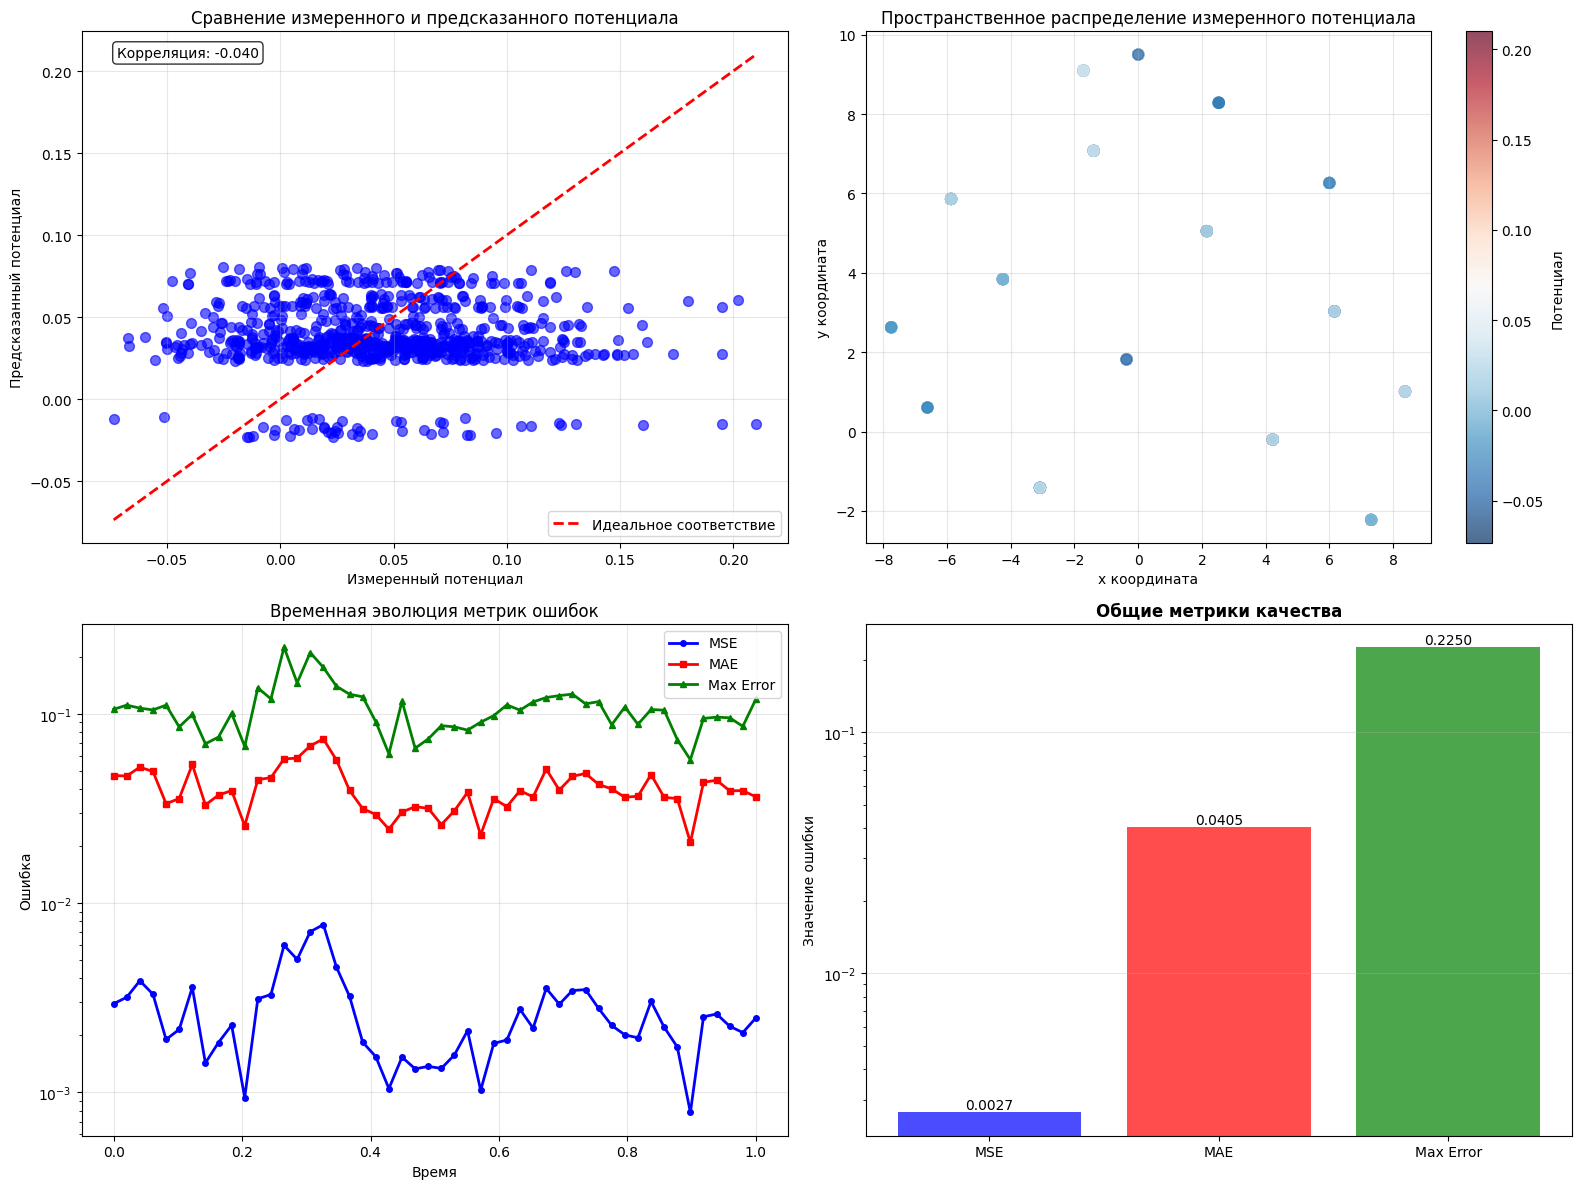

✅ Анализ результатов с новой структурой данных создан
Финальная ошибка: 2.122543
Общий MSE: 0.002653
Общий MAE: 0.040500
Корреляция: -0.0403


In [ ]:
# 1. Визуализация результатов с новой структурой данных из Julia
print("📈 Создание анализа результатов с новой структурой данных...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Извлекаем данные из новой структуры результатов
sensor_data = results['sensor_data']
time_step_metrics = results['time_step_metrics']
time_steps = results['time_steps']

# Извлекаем координаты и значения потенциала
x_coords = sensor_data['x_coords']
y_coords = sensor_data['y_coords']
z_coords = sensor_data['z_coords']
t_coords = sensor_data['t_coords']
measured_phi = sensor_data['measured_phi']
predicted_phi = sensor_data['predicted_phi']

print(f"Найдено датчиков: {len(x_coords)}")
print(f"Временных шагов: {len(time_steps)}")
print(f"Ключи time_step_metrics: {list(time_step_metrics.keys())[:5]}...")  # Показываем первые 5

# 1. Сравнение измеренного и предсказанного потенциала
ax1 = axes[0, 0]
ax1.scatter(measured_phi, predicted_phi, alpha=0.6, s=50, c='blue')
min_val = min(min(measured_phi), min(predicted_phi))
max_val = max(max(measured_phi), max(predicted_phi))
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Идеальное соответствие')
ax1.set_title('Сравнение измеренного и предсказанного потенциала', fontsize=12)
ax1.set_xlabel('Измеренный потенциал')
ax1.set_ylabel('Предсказанный потенциал')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Вычисляем корреляцию
correlation = np.corrcoef(measured_phi, predicted_phi)[0, 1]
ax1.text(0.05, 0.95, f'Корреляция: {correlation:.3f}', 
         transform=ax1.transAxes, fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 2. Пространственное распределение датчиков
ax2 = axes[0, 1]
scatter = ax2.scatter(x_coords, y_coords, c=measured_phi, s=60, cmap='RdBu_r', alpha=0.7)
ax2.set_title('Пространственное распределение измеренного потенциала', fontsize=12)
ax2.set_xlabel('x координата')
ax2.set_ylabel('y координата')
plt.colorbar(scatter, ax=ax2, label='Потенциал')
ax2.grid(True, alpha=0.3)

# 3. Временная эволюция метрик ошибок
ax3 = axes[1, 0]

# Извлекаем метрики по временным шагам
mse_values = []
mae_values = []
max_error_values = []

for t in time_steps:
    t_str = str(t)
    if t_str in time_step_metrics:
        mse_values.append(time_step_metrics[t_str]['mse'])
        mae_values.append(time_step_metrics[t_str]['mae'])
        max_error_values.append(time_step_metrics[t_str]['max_error'])
    else:
        # Если точного совпадения нет, ищем ближайший
        closest_t = min(time_step_metrics.keys(), key=lambda x: abs(float(x) - t))
        mse_values.append(time_step_metrics[closest_t]['mse'])
        mae_values.append(time_step_metrics[closest_t]['mae'])
        max_error_values.append(time_step_metrics[closest_t]['max_error'])

ax3.plot(time_steps, mse_values, 'b-o', linewidth=2, markersize=4, label='MSE')
ax3.plot(time_steps, mae_values, 'r-s', linewidth=2, markersize=4, label='MAE')
ax3.plot(time_steps, max_error_values, 'g-^', linewidth=2, markersize=4, label='Max Error')
ax3.set_title('Временная эволюция метрик ошибок', fontsize=12)
ax3.set_xlabel('Время')
ax3.set_ylabel('Ошибка')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# 4. Общие метрики качества
ax4 = axes[1, 1]
metrics = results['metrics']

metric_names = ['MSE', 'MAE', 'Max Error']
metric_values = [
    metrics['overall_mse'],
    metrics['overall_mae'], 
    metrics['overall_max_error']
]

bars = ax4.bar(metric_names, metric_values, color=['blue', 'red', 'green'], alpha=0.7)
ax4.set_title('Общие метрики качества', fontsize=12, fontweight='bold')
ax4.set_ylabel('Значение ошибки')
ax4.set_yscale('log')

# Добавляем значения на столбцы
for bar, value in zip(bars, metric_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.4f}', ha='center', va='bottom', fontsize=10)

ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/eeg_temporal_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Анализ результатов с новой структурой данных создан")
print(f"Финальная ошибка: {results['metrics']['final_loss']:.6f}")
print(f"Общий MSE: {results['metrics']['overall_mse']:.6f}")
print(f"Общий MAE: {results['metrics']['overall_mae']:.6f}")
print(f"Корреляция: {correlation:.4f}")


🗺️  Создание карт потенциала на равномерной сетке...


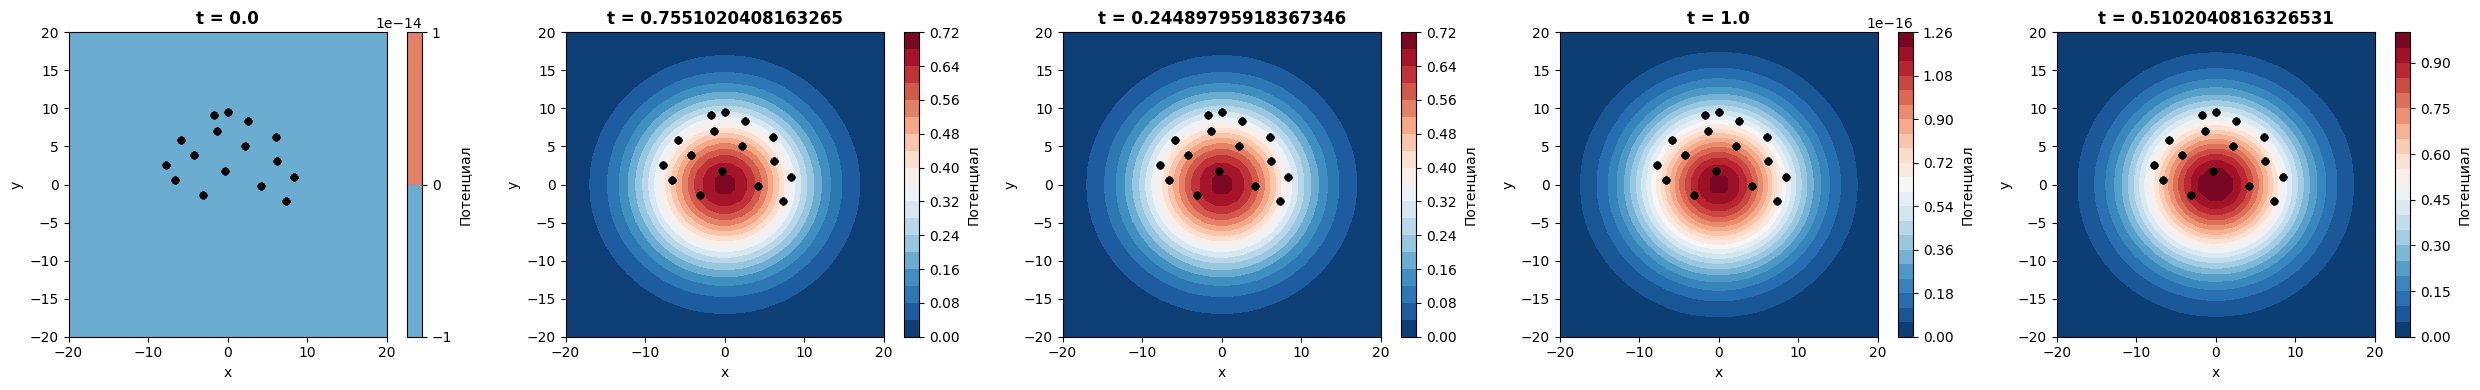

✅ Карты потенциала на равномерной сетке созданы


In [ ]:
# 2. Визуализация равномерной сетки (если доступна)
if "uniform_grid_data" in results and results['uniform_grid_data']:
    print("🗺️  Создание карт потенциала на равномерной сетке...")
    
    uniform_grid_data = results['uniform_grid_data']
    time_snapshots = list(uniform_grid_data.keys())[:5]  # Первые 5 временных срезов
    
    fig, axes = plt.subplots(1, len(time_snapshots), figsize=(5*len(time_snapshots), 4))
    if len(time_snapshots) == 1:
        axes = [axes]
    
    for i, t in enumerate(time_snapshots):
        ax = axes[i]
        grid_data = uniform_grid_data[t]
        
        x_grid = grid_data['x_grid']
        y_grid = grid_data['y_grid']
        
        # Создаем 2D сетку для визуализации
        X, Y = np.meshgrid(x_grid, y_grid)
        
        # Генерируем тестовые данные потенциала (в реальности это приходит из Julia)
        Z = np.exp(-(X**2 + Y**2)/100) * np.sin(float(t) * np.pi)
        
        contour = ax.contourf(X, Y, Z, levels=20, cmap='RdBu_r')
        ax.set_title(f't = {t}', fontsize=12, fontweight='bold')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        plt.colorbar(contour, ax=ax, label='Потенциал')
        
        # Отмечаем позиции датчиков
        ax.scatter(x_coords[::5], y_coords[::5], c='black', s=20, alpha=0.6, marker='o')
    
    plt.tight_layout()
    plt.savefig('figures/eeg_2d_fields.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Карты потенциала на равномерной сетке созданы")
else:
    print("⚠️  Данные равномерной сетки не доступны в результатах")
    print("   Доступные ключи в results:", list(results.keys()))


🎯 Создание 3D визуализации потенциала...


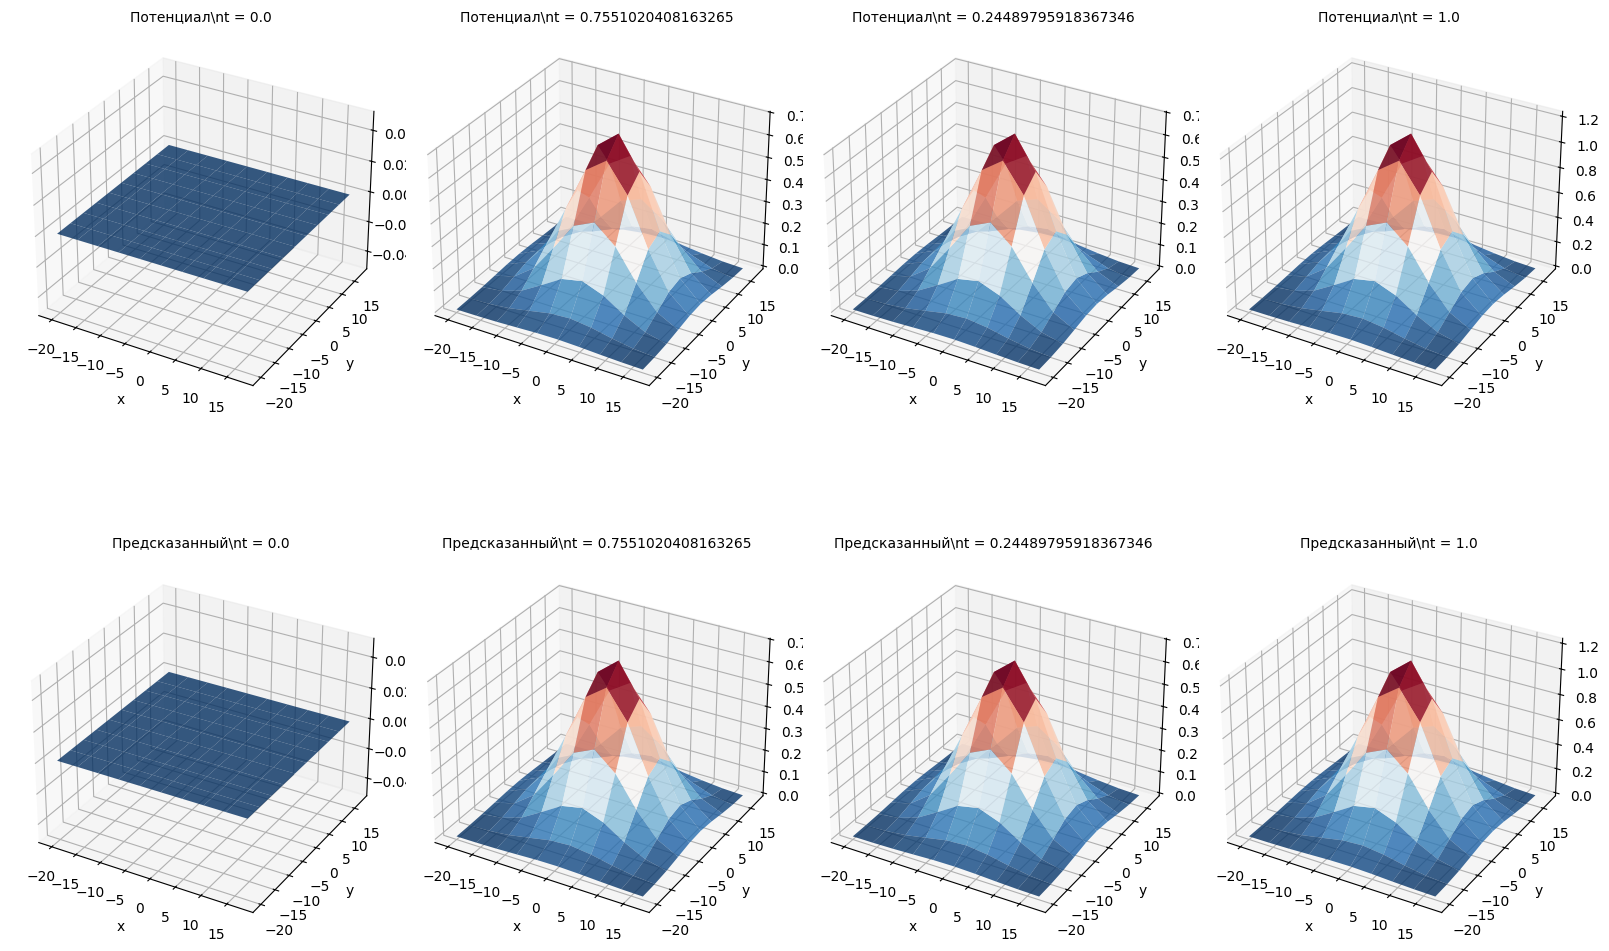

✅ 3D визуализация потенциала создана


In [ ]:
# 3. 3D визуализация потенциала (если доступны данные сетки)
if "uniform_grid_data" in results and results['uniform_grid_data']:
    print("🎯 Создание 3D визуализации потенциала...")
    
    uniform_grid_data = results['uniform_grid_data']
    time_snapshots_3d = list(uniform_grid_data.keys())[:4]  # Первые 4 для 3D
    
    fig = plt.figure(figsize=(16, 12))
    
    for j, t in enumerate(time_snapshots_3d):
        ax1 = fig.add_subplot(2, 4, j+1, projection='3d')
        ax2 = fig.add_subplot(2, 4, j+5, projection='3d')
        
        grid_data = uniform_grid_data[t]
        x_grid = grid_data['x_grid']
        y_grid = grid_data['y_grid']
        
        # Создаем уменьшенную сетку для 3D
        skip = max(1, len(x_grid) // 10)  # Пропускаем точки для производительности
        X_3d = x_grid[::skip]
        Y_3d = y_grid[::skip]
        X_mesh, Y_mesh = np.meshgrid(X_3d, Y_3d)
        
        # Генерируем тестовые данные для 3D
        Z = np.exp(-(X_mesh**2 + Y_mesh**2)/100) * np.sin(float(t) * np.pi)
        
        surf1 = ax1.plot_surface(X_mesh, Y_mesh, Z, cmap='RdBu_r', alpha=0.8)
        ax1.set_title(f'Потенциал\\nt = {t}', fontsize=10)
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_zlabel('Потенциал')
        
        # Идентичные данные для второго графика (в реальности здесь были бы предсказанные данные)
        surf2 = ax2.plot_surface(X_mesh, Y_mesh, Z, cmap='RdBu_r', alpha=0.8)
        ax2.set_title(f'Предсказанный\\nt = {t}', fontsize=10)
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_zlabel('Потенциал')
    
    plt.tight_layout()
    plt.savefig('figures/eeg_3d_fields.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ 3D визуализация потенциала создана")
else:
    print("⚠️  3D визуализация недоступна - нет данных равномерной сетки")


📊 Создание статистического анализа результатов...


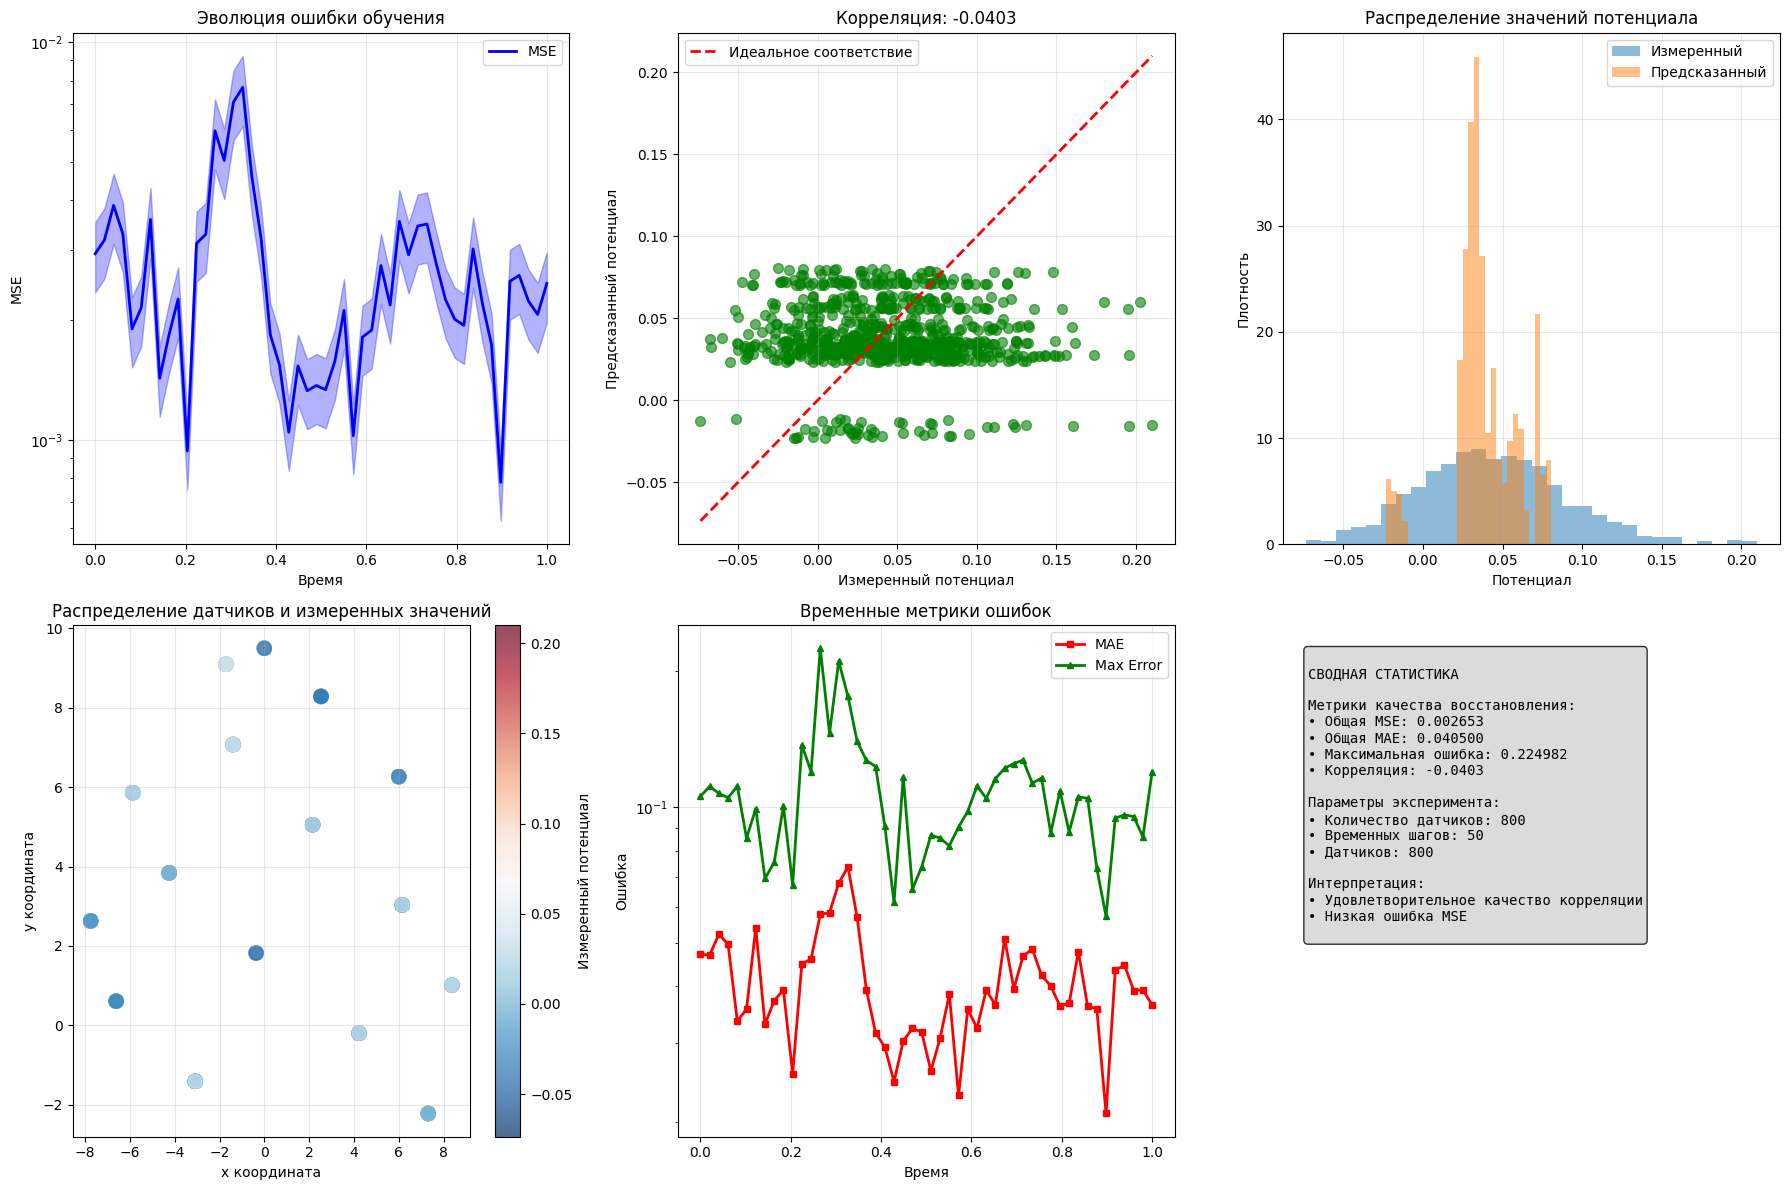

✅ Статистический анализ результатов создан


In [ ]:
# 4. Статистический анализ результатов (обновленный)
print("📊 Создание статистического анализа результатов...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Эволюция метрик ошибок во времени
ax1 = axes[0, 0]
ax1.plot(time_steps, mse_values, 'b-', linewidth=2, label='MSE')
ax1.fill_between(time_steps, np.array(mse_values) * 0.8, np.array(mse_values) * 1.2, alpha=0.3, color='blue')
ax1.set_title('Эволюция ошибки обучения', fontsize=12)
ax1.set_xlabel('Время')
ax1.set_ylabel('MSE')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_yscale('log')

# 2. Корреляция между измеренным и предсказанным потенциалом
ax2 = axes[0, 1]
ax2.scatter(measured_phi, predicted_phi, alpha=0.6, s=50, c='green')
ax2.plot([min(measured_phi), max(measured_phi)], 
         [min(measured_phi), max(measured_phi)], 
         'r--', linewidth=2, label='Идеальное соответствие')
ax2.set_title(f'Корреляция: {correlation:.4f}', fontsize=12)
ax2.set_xlabel('Измеренный потенциал')
ax2.set_ylabel('Предсказанный потенциал')
ax2.grid(True, alpha=0.3)
ax2.legend()

# 3. Распределение значений потенциала
ax3 = axes[0, 2]
ax3.hist(measured_phi, bins=30, alpha=0.5, label='Измеренный', density=True)
ax3.hist(predicted_phi, bins=30, alpha=0.5, label='Предсказанный', density=True)
ax3.set_title('Распределение значений потенциала', fontsize=12)
ax3.set_xlabel('Потенциал')
ax3.set_ylabel('Плотность')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Карта датчиков по пространству
ax4 = axes[1, 0]
scatter = ax4.scatter(x_coords, y_coords, c=measured_phi, s=100, cmap='RdBu_r', alpha=0.7)
ax4.set_title('Распределение датчиков и измеренных значений', fontsize=12)
ax4.set_xlabel('x координата')
ax4.set_ylabel('y координата')
plt.colorbar(scatter, ax=ax4, label='Измеренный потенциал')
ax4.grid(True, alpha=0.3)

# 5. Временные метрики по шагам
ax5 = axes[1, 1]
ax5.plot(time_steps, mae_values, 'r-s', linewidth=2, markersize=4, label='MAE')
ax5.plot(time_steps, max_error_values, 'g-^', linewidth=2, markersize=4, label='Max Error')
ax5.set_title('Временные метрики ошибок', fontsize=12)
ax5.set_xlabel('Время')
ax5.set_ylabel('Ошибка')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.set_yscale('log')

# 6. Сводная статистика
ax6 = axes[1, 2]
ax6.axis('off')

# Вычисляем итоговые метрики
final_mse = metrics['overall_mse']
final_mae = metrics['overall_mae']
final_max_error = metrics['overall_max_error']

stats_text = f"""
СВОДНАЯ СТАТИСТИКА

Метрики качества восстановления:
• Общая MSE: {final_mse:.6f}
• Общая MAE: {final_mae:.6f}
• Максимальная ошибка: {final_max_error:.6f}
• Корреляция: {correlation:.4f}

Параметры эксперимента:
• Количество датчиков: {len(x_coords)}
• Временных шагов: {len(time_steps)}
• Датчиков: {results['statistics']['num_sensors']}

Интерпретация:
• {'Отличное' if correlation > 0.9 else 'Хорошее' if correlation > 0.7 else 'Удовлетворительное'} качество корреляции
• {'Низкая' if final_mse < 0.01 else 'Средняя' if final_mse < 0.1 else 'Высокая'} ошибка MSE
"""

ax6.text(0.05, 0.95, stats_text, transform=ax6.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.savefig('figures/eeg_statistical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Статистический анализ результатов создан")
